## Run DCR Analysis on All Relevant OpSims (WFD Only)
**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 04-01-21
<br>**Short description:**
This notebook analyze the DCR metric results evaluated on All OpSims in preparation for the SCOC cadence notes on DCR in LSST.

### 0. Software Setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')
%matplotlib inline

In [3]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [5]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add path
sys.path.insert(0, '../scripts/')
sys.path.insert(0, '../run_info//')

# import convenience functions
from opsimUtils import *

### 1. Read data from disk

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/WFDAll_v2_bin_15_040121/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/WFDAll_v2_bin_15_040121/MetricData/'

In [7]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [8]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'SFError_22.15_u'), (2, 'SFError_24.15_u'), (3, 'SFError_22_g'), (4, 'SFError_24_g')]


#### Keep only result for the relevant OpSims

In [9]:
# read in the list of relevant runs
runs_file = open('../run_info/runs_list.txt', 'r')
runs_list = runs_file.read().split('\n')
runs_list[:5]

['agnddf_v1.5_10yrs',
 'alt_dust_v1.5_10yrs',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs',
 'barebones_nexp2_v1.6_10yrs',
 'barebones_v1.6_10yrs']

In [10]:
# select metric results for the relevant opsims
final_bundleDicts = {key:value for (key, value) in bundleDicts.items() if key in runs_list}
final_resultDbs = {key:value for (key, value) in resultDbsView.items() if key in runs_list}

### 2. Make plots

In [11]:
# take Lynne's notes on families
sys.path.insert(0, '../data/run_info/')
import run_infos as ri

# gather family info, but remove version_baselines
families = ri.FamilyInfo()
fam_db = {key:value for (key, value) in families.family.items() if key != 'version_baselines'}
family_ls = list(fam_db.keys())
comp_runs = {key:value for (key, value) in families.family_baseline.items() if key != 'version_baselines'}

In [12]:
# get the metrics for plotting
Key1, Key2 = (2, 'SFError_24.15_u'), (4, 'SFError_24_g')
KeyNames = ['SFError_24.15_u', 'SFError_24_g']

#### 2.1 Get summary statistics (Median, Mean, etc.)

In [13]:
# get summary names
summaryNames = getSummaryStatNames(final_resultDbs['baseline_v1.5_10yrs'], 
                                   KeyNames[0])[0]['StatNames']

# loop through metric Keys and summaries -> combine into one pandas df
summary_dfs = []
for KeyName in KeyNames:
    for summaryName in ['Median']:
        summary_df = getSummary(
            final_resultDbs, 
            KeyName, 
            summaryName)[['summaryValue', 'runName']].rename(columns={'summaryValue':
                                                            f'{KeyName}_{summaryName}'})
        summary_dfs.append(summary_df.set_index('runName'))

summary_df_all = summary_dfs[0].join(summary_dfs[1:]).reset_index()

In [14]:
# assign family
comp_run = families.family_baseline
summary_df_all['family'] = ''
for familyName in comp_run:
    if familyName is not 'version_baselines':
        non_comp_runs = [run for run in fam_db[familyName] if run is not comp_run[familyName]]
        summary_df_all.loc[summary_df_all.runName.isin(non_comp_runs), 'family'] = familyName

# if not assigned, it must be one of the baselines
summary_df_all.loc[summary_df_all.family == '', 'family'] = 'baseline'

# sort by family
summary_df_all = summary_df_all.sort_values('family').set_index('runName')

#### 2.2 One plot for each experiment (family)
__Note:__ Each comparison plot is normalized differently (used different nomalization run)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


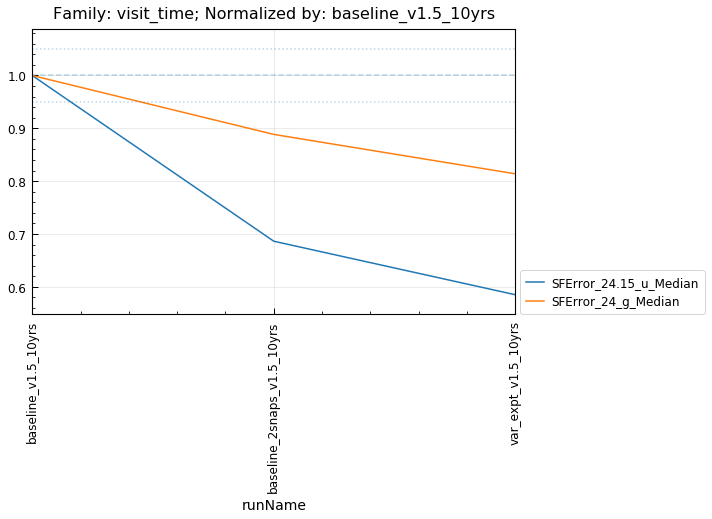

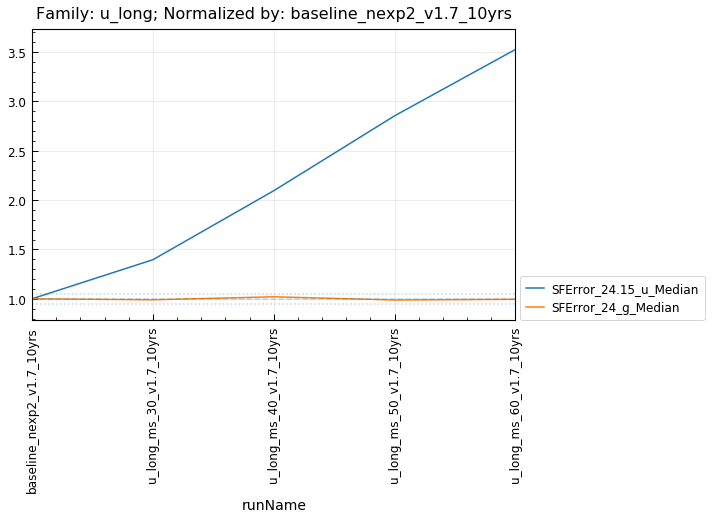

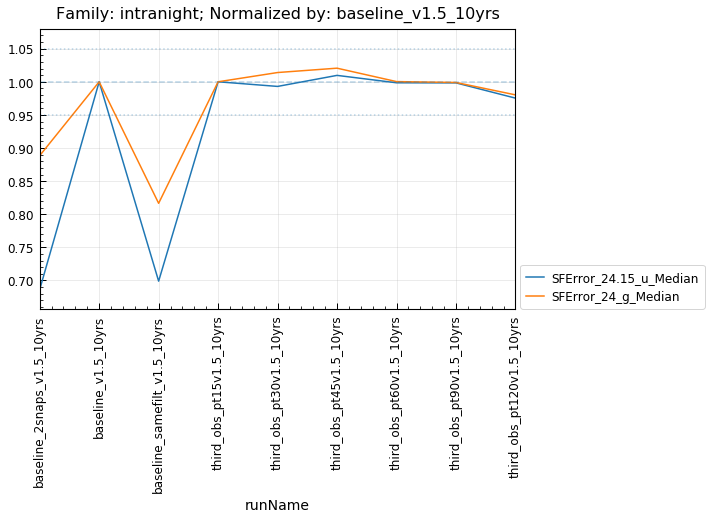

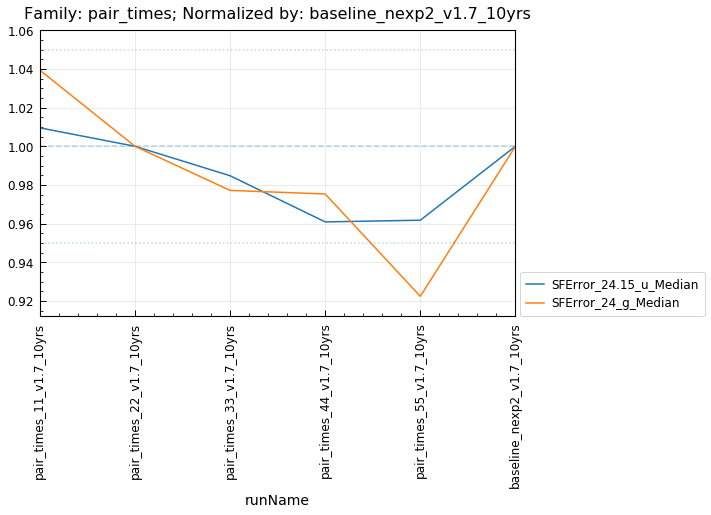

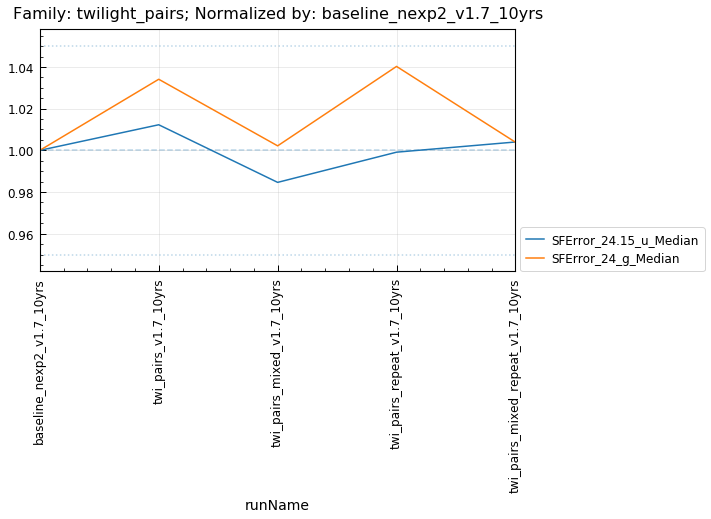

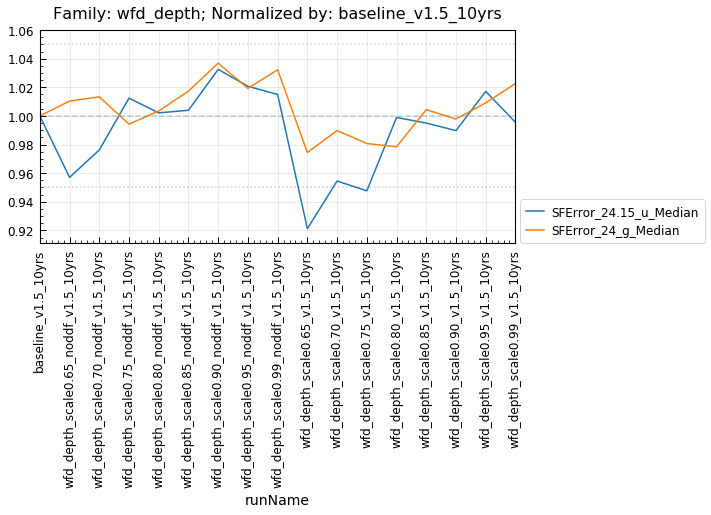

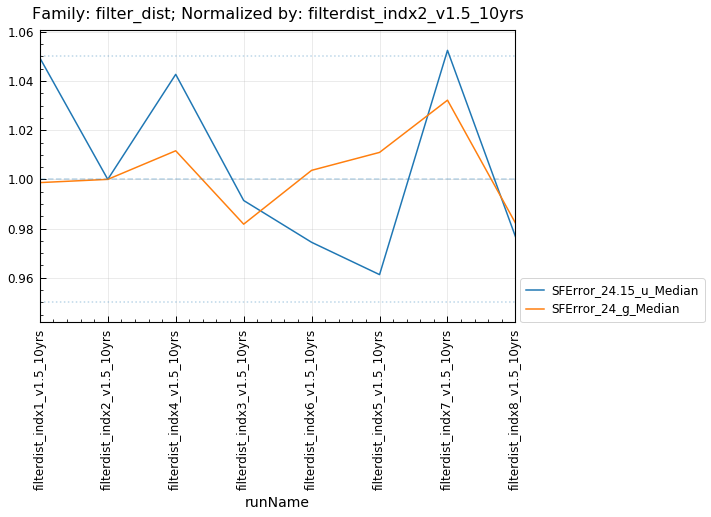

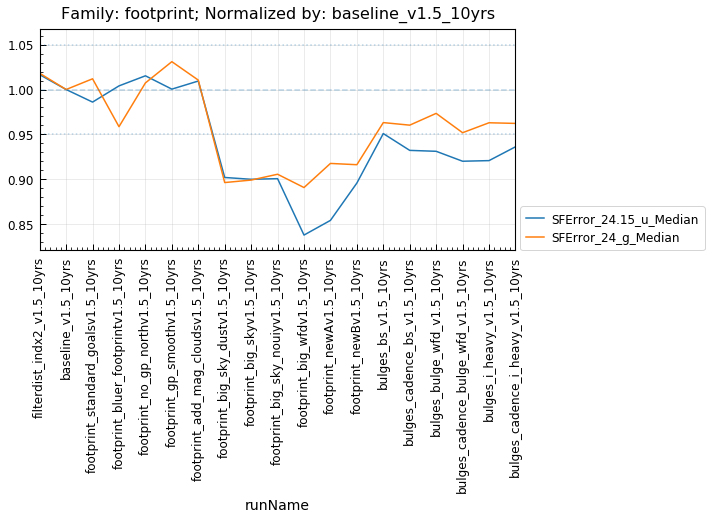

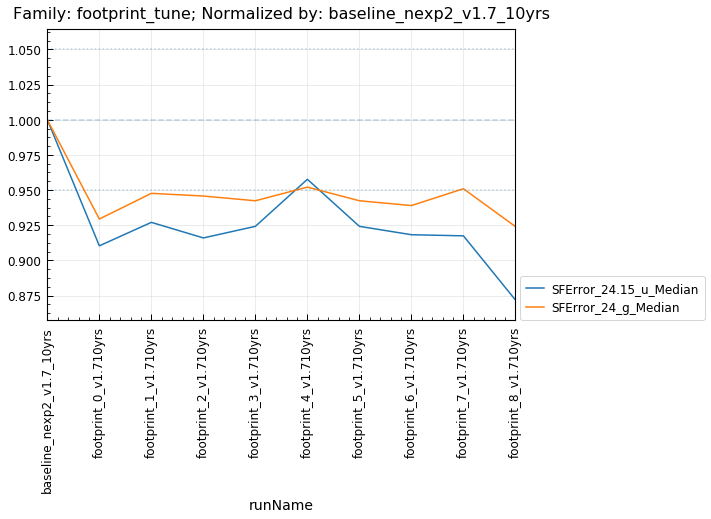

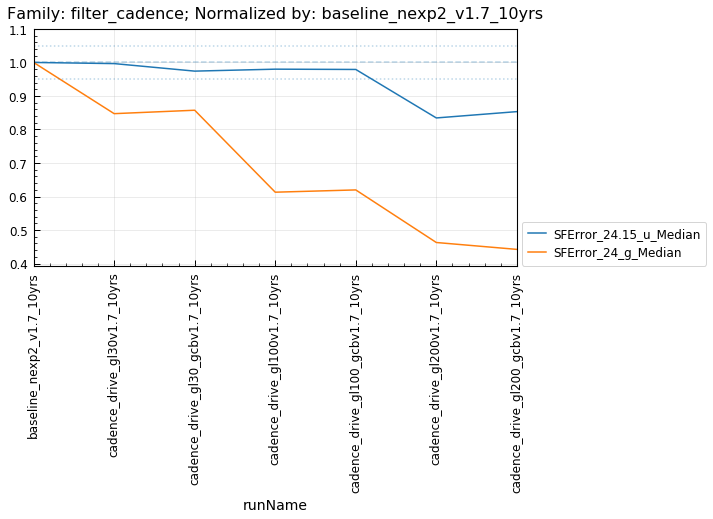

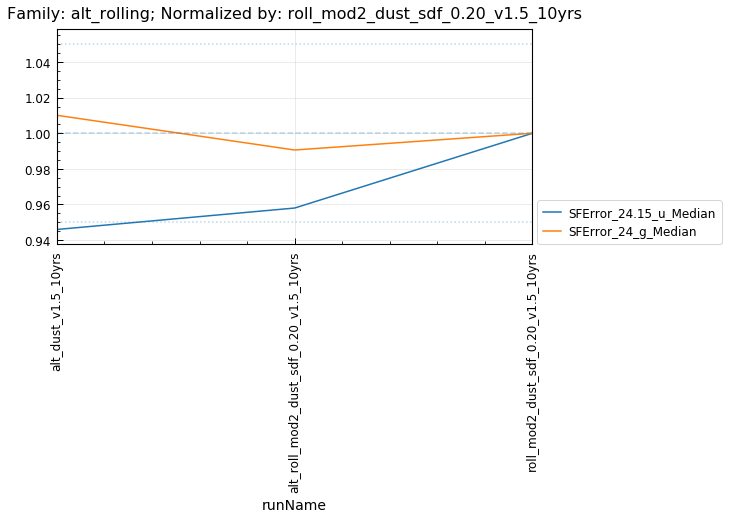

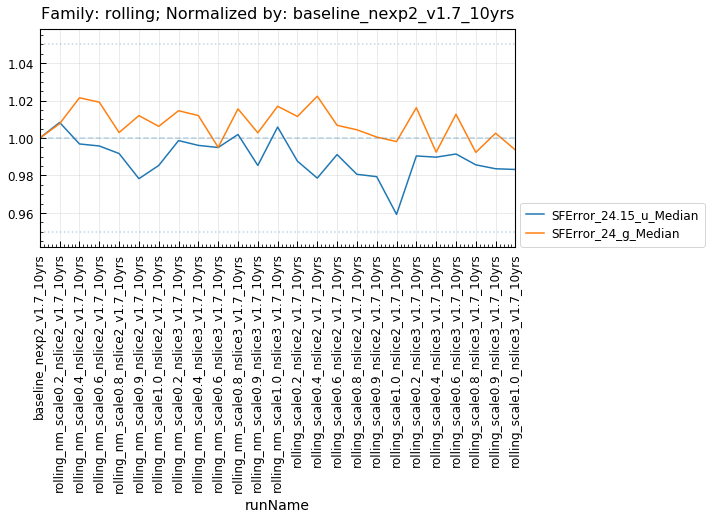

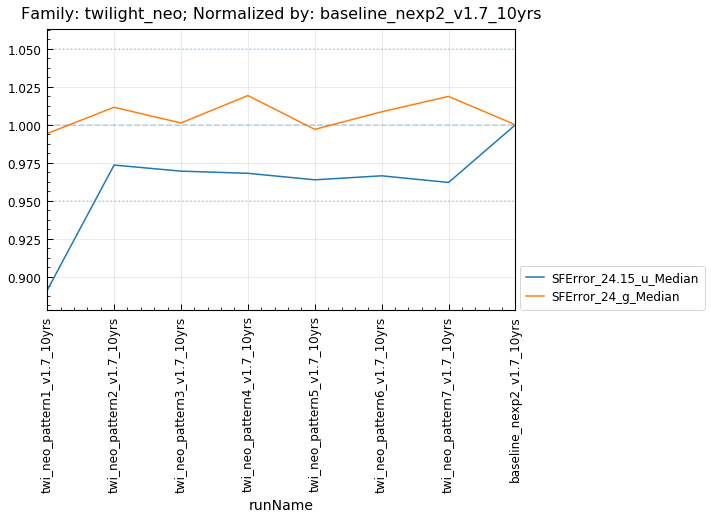

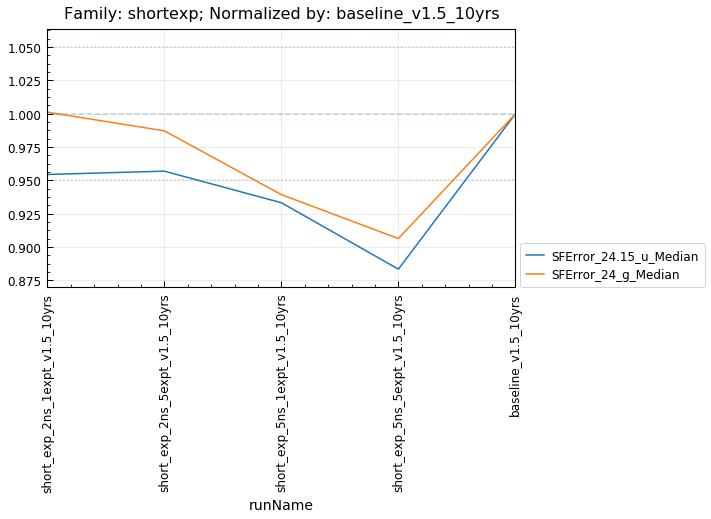

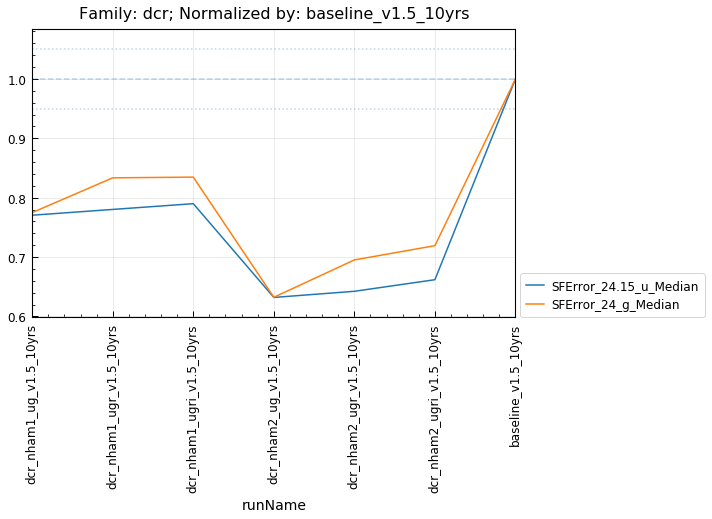

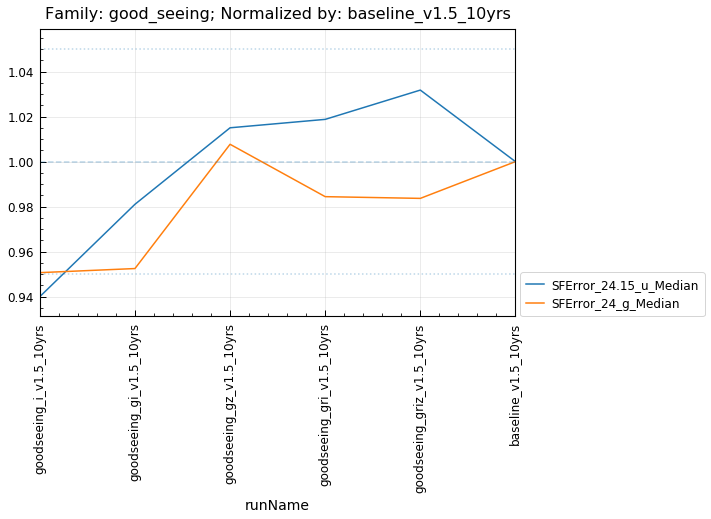

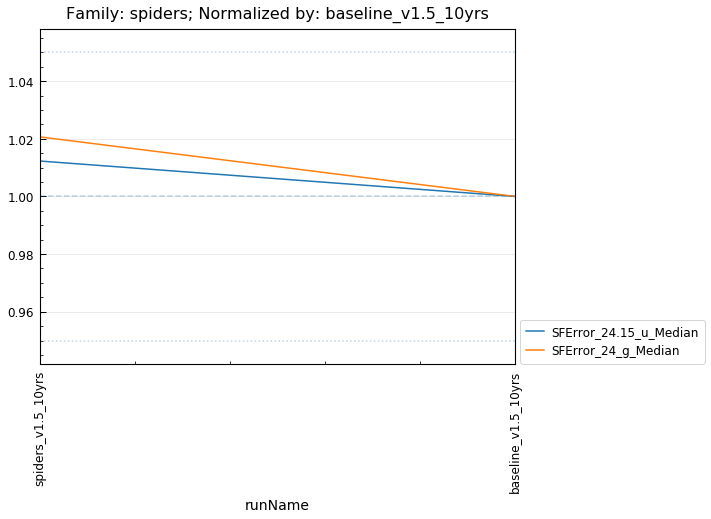

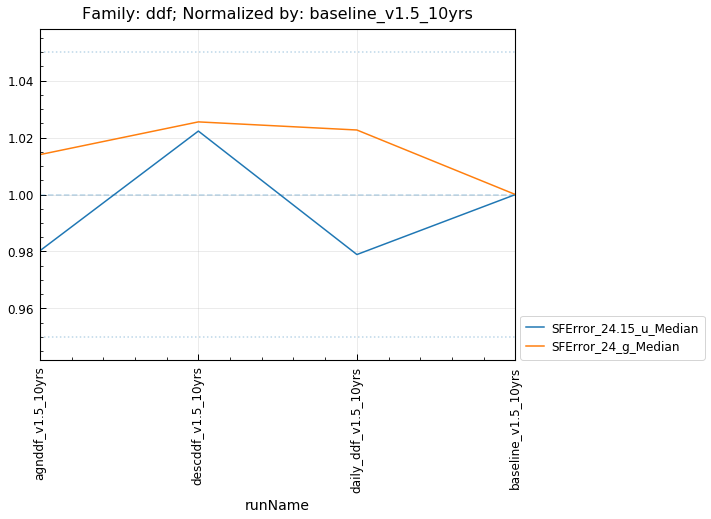

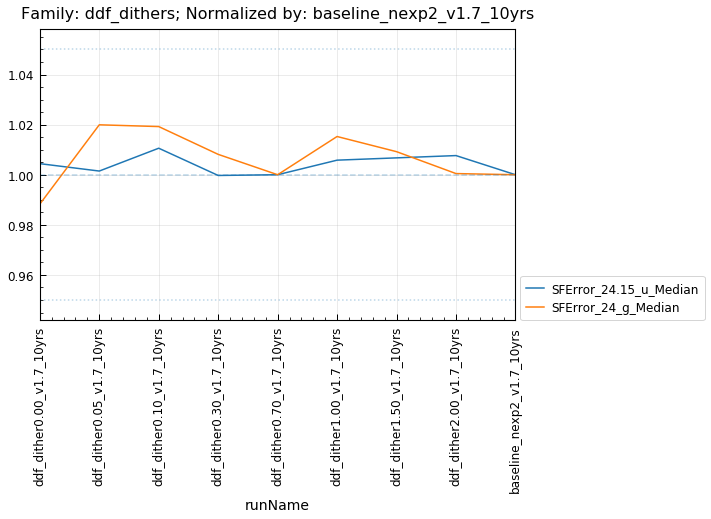

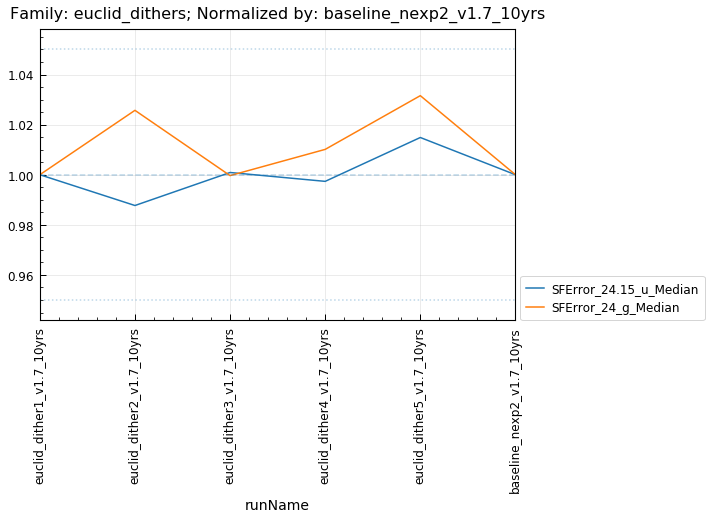

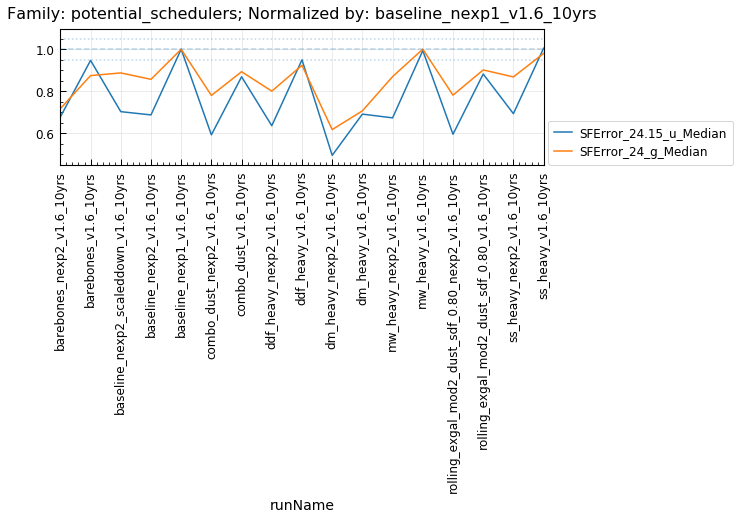

In [15]:
for family in family_ls[:]:
    norm_run = families.family_baseline[family]
    runs_in_fam = fam_db[family]
    normed_df = ri.norm_df(summary_df_all.loc[runs_in_fam, :].drop("family",axis=1), norm_run, 
                           invert_cols=[KeyName+'_Median' for KeyName in KeyNames])
    ri.plot(normed_df, figsize=(10, 7))
    plt.title(f'Family: {family}; Normalized by: {norm_run}')